# Dataset 2 data processed in here

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import typing
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from typing import Union, List, Tuple
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors3D
from rdkit.Chem import GraphDescriptors
from tqdm import tqdm

In [2]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neural_network import MLPRegressor

### Helper functions

In [3]:
def find_pattern_count(molecule: Chem.Mol, pattern: Chem.Mol) -> int:
    result = molecule.GetSubstructMatches(pattern)
    return len(result)

def drawSmils(smils: str):
    smilsChromoChem = Chem.MolFromSmiles(smils)
    drawing = Draw.MolToMPL(smilsChromoChem, size=(450,450))


# Read data

In [4]:
qm9_database = pd.read_csv("qm9.csv")
qm9_database["RDKit_Mol_Class"] = qm9_database["smiles"].apply(Chem.MolFromSmiles)
only_solids = pd.read_json("only_solids_features.json").reset_index(drop=True)
only_solids_conf = pd.read_json("only_solids_conf_features.json").reset_index(drop=True)
only_solids["RDKit_Mol_Class"] = only_solids["Chromophore"].apply(Chem.MolFromSmiles)
only_solids_conf["RDKit_Mol_Class"] = only_solids_conf["Chromophore"].apply(Chem.MolFromSmiles)

In [5]:
first_4_cols = ["Chromophore", 'qm9_pattern_indexes', 'RDKit_Mol_Class', "Emission max (nm)"]
only_solids = pd.concat([only_solids[first_4_cols], only_solids.drop(columns=first_4_cols)], axis=1)
only_solids_conf = pd.concat([only_solids_conf[first_4_cols], only_solids_conf.drop(columns=first_4_cols)], axis=1)

In [6]:
x = pd.concat((only_solids["Emission max (nm)"], only_solids_conf["Emission max (nm)"]), axis=1)
x.columns = ["dataset 1", "dataset 2"]

In [7]:
xx = x.melt(var_name="Dataset", value_name="Emission max (nm)").dropna()

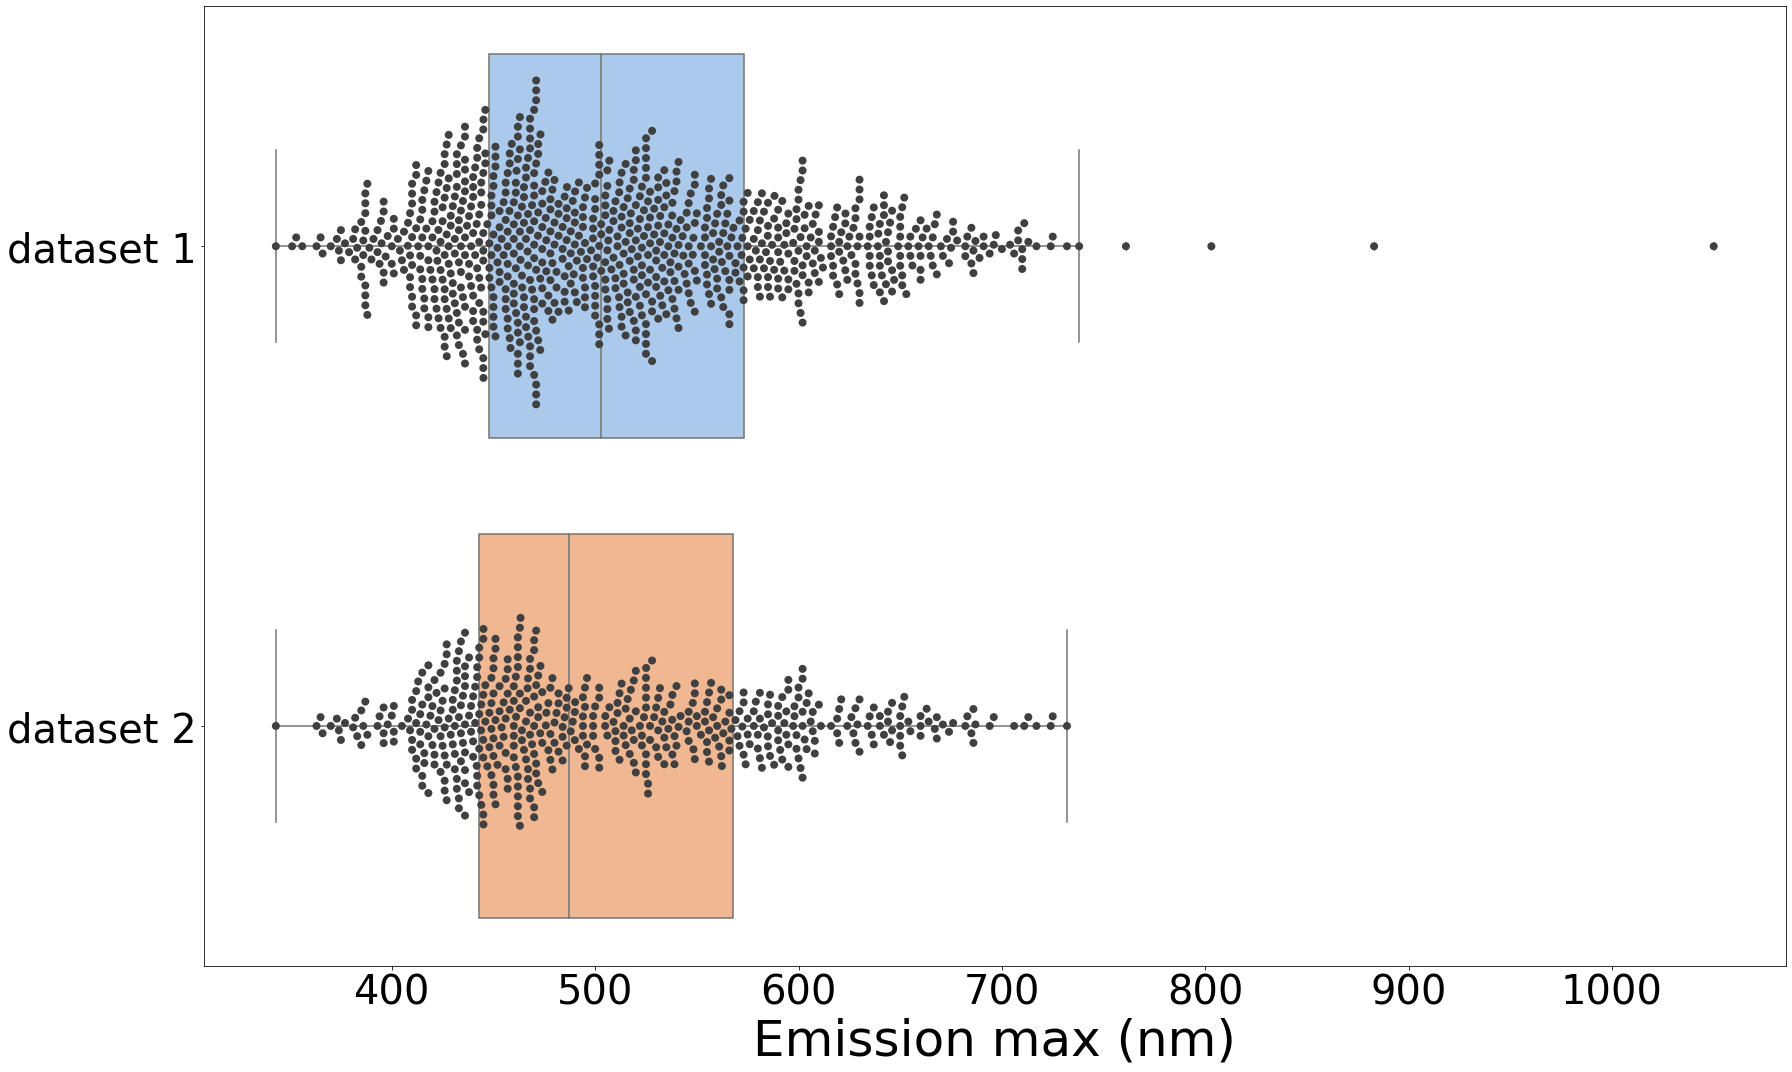

In [8]:
fig, ax = plt.subplots(figsize=(25,15))
sns.boxplot(y="Dataset", x="Emission max (nm)", data=xx, orient="h", ax=ax, palette="pastel")
sns.swarmplot(y="Dataset", x="Emission max (nm)", data=xx, orient="h", ax=ax, color="0.25", size=8)
ax.set_ylabel("", fontsize=50)
ax.set_xlabel("Emission max (nm)", fontsize=50)
ax.tick_params(labelsize=40)
plt.tight_layout()

In [9]:
fig.savefig("emissions_boxplots.pdf")

# Below is important cell

In [10]:
only_solids = only_solids_conf

In [11]:
descriptors_names = [ x[0] for x in Descriptors._descList ]
len(descriptors_names)

208

In [12]:
scaler = StandardScaler()
scaler.fit(only_solids[descriptors_names])
only_solids = pd.concat([only_solids[only_solids.columns.drop(descriptors_names)].reset_index(drop=True), pd.DataFrame(scaler.transform(only_solids[descriptors_names]), columns=descriptors_names)], axis=1)

In [13]:
only_solids.drop(only_solids.std()[only_solids.std()==0].index, axis=1, inplace=True)
only_solids.shape

(558, 1127)

In [14]:
nans_cols = only_solids.columns[only_solids.isna().any()]
nans_cols

Index(['Emission max (nm)'], dtype='object')

In [15]:
only_solids.dropna(subset=nans_cols, axis=0, inplace=True)
only_solids.shape

(523, 1127)

In [16]:
universal_features = list(only_solids.columns)[4:]
universal_features_conf = list(only_solids_conf.columns)[4:]

In [17]:
model_data_conf_x = only_solids[universal_features]
model_data_conf_y = only_solids["Emission max (nm)"]

In [18]:
all_quantum_features = list(qm9_database.columns.drop(["RDKit_Mol_Class", "mol_id", "smiles"]))

In [19]:
cv_scores = pd.DataFrame(columns=["model", "algorithm", "scoring_type", "scoring_value"])


# Model 1

In [20]:
rfr1 = RandomForestRegressor(random_state=0)

linear_model = LinearRegression()

reg = GradientBoostingRegressor(random_state=0)

In [21]:
lin_model1_features = list(set(model_data_conf_x.columns) & set(descriptors_names))

In [22]:
model = "model 1"
kf = KFold(n_splits=10, shuffle=True, random_state=1)
for scor_type in ["neg_mean_squared_error", "r2", "max_error", "neg_mean_absolute_error"]:
    for name, algorithm in [("Gradient Boosting", reg), ("Random Forest", rfr1), ("Linear Regression", linear_model)]:
        scor = pd.DataFrame([{"model": model, "algorithm": name, "scoring_type": scor_type, "scoring_value":
                            cross_val_score(algorithm, model_data_conf_x, model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }])
        cv_scores = cv_scores.append(scor, ignore_index=True)
    cv_scores = cv_scores.append(
    pd.DataFrame([{"model": model, "algorithm": "Linear Regression 1", "scoring_type": scor_type, "scoring_value":
                        cross_val_score(linear_model, model_data_conf_x[lin_model1_features], model_data_conf_y, cv=kf, scoring=scor_type).mean()
                        }]), ignore_index=True)

# Model 2

In [23]:
def get_features(row, database: pd.DataFrame, features: Union[List[str], str]) -> None:
    for index in row["qm9_pattern_indexes"]:
        count = find_pattern_count(row["RDKit_Mol_Class"], database["RDKit_Mol_Class"][index])
        for feature in features:
            value = count*database[feature][index]
            row[feature] += value
    return row

In [24]:
features = all_quantum_features

In [25]:
only_solids[features] = 0

In [26]:
only_solids = only_solids.apply(get_features, database=qm9_database, features=features, axis=1)

In [27]:
model_data_conf_x = only_solids[universal_features+features]
model_data_conf_y = only_solids["Emission max (nm)"]

In [28]:
linear_model2 = LinearRegression()

In [29]:
lin_model1_features = list(set(model_data_conf_x.columns) & set(descriptors_names))

In [30]:
model = "model 2"

kf = KFold(n_splits=10, shuffle=True, random_state=1)
for scor_type in ["neg_mean_squared_error", "r2", "max_error", "neg_mean_absolute_error"]:
    for name, algorithm in [("Gradient Boosting", reg), ("Random Forest", rfr1), ("Linear Regression", linear_model)]:
        scor = pd.DataFrame([{"model": model, "algorithm": name, "scoring_type": scor_type, "scoring_value":
                            cross_val_score(algorithm, model_data_conf_x, model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }])
        cv_scores = cv_scores.append(scor, ignore_index=True)
    cv_scores = cv_scores.append(
        pd.DataFrame([{"model": model, "algorithm": "Linear Regression 2", "scoring_type": scor_type, "scoring_value":
                            cross_val_score(linear_model2, model_data_conf_x[features], model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }]), ignore_index=True)
    cv_scores = cv_scores.append(
        pd.DataFrame([{"model": model, "algorithm": "Linear Regression 1", "scoring_type": scor_type, "scoring_value":
                            cross_val_score(linear_model2, model_data_conf_x[features+lin_model1_features], model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }]), ignore_index=True)

# Model 3

In [31]:
def get_features(row, database: pd.DataFrame, features: Union[List[str], str]) -> None:
    for index in row["qm9_pattern_indexes"]:
        count = find_pattern_count(row["RDKit_Mol_Class"], database["RDKit_Mol_Class"][index])
        for feature in features:
            value = database[feature][index]*count
            row[feature] += value
    return row

In [32]:
features = all_quantum_features

In [33]:
only_solids[features] = 0

In [34]:
only_solids = only_solids.apply(get_features, database=qm9_database, features=features, axis=1)

In [35]:
model_data_conf_x = only_solids[features]
model_data_conf_y = only_solids["Emission max (nm)"]

In [36]:
model = "model 3"
kf = KFold(n_splits=10, shuffle=True, random_state=1)
for scor_type in ["neg_mean_squared_error", "r2", "max_error", "neg_mean_absolute_error"]:
    for name, algorithm in [("Gradient Boosting", reg), ("Random Forest", rfr1), ("Linear Regression", linear_model)]:
        scor = pd.DataFrame([{"model": model, "algorithm": name, "scoring_type": scor_type, "scoring_value":
                            cross_val_score(algorithm, model_data_conf_x, model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }])
        cv_scores = cv_scores.append(scor, ignore_index=True)
    cv_scores = cv_scores.append(
        pd.DataFrame([{"model": model, "algorithm": "Linear Regression 2", "scoring_type": scor_type, "scoring_value":
                            cross_val_score(linear_model2, model_data_conf_x[features], model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }]), ignore_index=True)
    cv_scores = cv_scores.append(
        pd.DataFrame([{"model": model, "algorithm": "Linear Regression 1", "scoring_type": scor_type, "scoring_value":
                            cross_val_score(linear_model2, model_data_conf_x[features], model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }]), ignore_index=True)

# Model 4

In [37]:
def get_features(row, database: pd.DataFrame, features: Union[List[str], str]):
    for index in row["qm9_pattern_indexes"]:
        count = find_pattern_count(row["RDKit_Mol_Class"], database["RDKit_Mol_Class"][index])
        for feature in features:
            row[f"{feature}*mu"] += count*database[feature][index]*database["mu"][index]
            row[f"{feature}*alpha"] += count*database[feature][index]*database["alpha"][index]
    return row

In [38]:
features = ["homo*mu", "homo*alpha", "lumo*mu", "lumo*alpha", "gap*alpha", "gap*mu", "r2*mu", "r2*alpha", "zpve*mu", "zpve*alpha"]

In [39]:
only_solids[features] = 0

In [40]:
only_solids = only_solids.apply(get_features, database=qm9_database, features=["homo", "lumo", "gap", "r2", "zpve"], axis=1)

In [41]:
model_data_conf_x = only_solids[universal_features+features]
model_data_conf_y = only_solids["Emission max (nm)"]

In [42]:
model = "model 4"
kf = KFold(n_splits=10, shuffle=True, random_state=1)
for scor_type in ["neg_mean_squared_error", "r2", "max_error", "neg_mean_absolute_error"]:
    for name, algorithm in [("Gradient Boosting", reg), ("Random Forest", rfr1), ("Linear Regression", linear_model)]:
        scor = pd.DataFrame([{"model": model, "algorithm": name, "scoring_type": scor_type, "scoring_value":
                            cross_val_score(algorithm, model_data_conf_x, model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }])
        cv_scores = cv_scores.append(scor, ignore_index=True)
    cv_scores = cv_scores.append(
        pd.DataFrame([{"model": model, "algorithm": "Linear Regression 2", "scoring_type": scor_type, "scoring_value":
                            cross_val_score(linear_model2, model_data_conf_x[features], model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }]), ignore_index=True)
    cv_scores = cv_scores.append(
        pd.DataFrame([{"model": model, "algorithm": "Linear Regression 1", "scoring_type": scor_type, "scoring_value":
                            cross_val_score(linear_model2, model_data_conf_x[features+lin_model1_features], model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }]), ignore_index=True)

# Model 5

In [43]:
def get_features(row, database: pd.DataFrame, features: Union[List[str], str]):
    for index in row["qm9_pattern_indexes"]:
        count = find_pattern_count(row["RDKit_Mol_Class"], database["RDKit_Mol_Class"][index])
        for feature in features:
            row[f"{feature}*(mu+alpha)"] += count*database[feature][index]*(database["mu"][index]+database["alpha"][index])
        row["mu+alpha"] += count*(database["mu"][index]+database["alpha"][index])
    return row

In [44]:
features= ["homo*(mu+alpha)", "lumo*(mu+alpha)", "mu+alpha", "gap*(mu+alpha)", "r2*(mu+alpha)", "zpve*(mu+alpha)"]

In [45]:
only_solids[features] = 0

In [46]:
only_solids = only_solids.apply(get_features, database=qm9_database, features=["homo", "lumo", "gap", "r2", "zpve"], axis=1)

In [47]:
model_data_conf_x = only_solids[universal_features+features]
model_data_conf_y = only_solids["Emission max (nm)"]

In [48]:
model = "model 5"
kf = KFold(n_splits=10, shuffle=True, random_state=1)
for scor_type in ["neg_mean_squared_error", "r2", "max_error", "neg_mean_absolute_error"]:
    for name, algorithm in [("Gradient Boosting", reg), ("Random Forest", rfr1), ("Linear Regression", linear_model)]:
        scor = pd.DataFrame([{"model": model, "algorithm": name, "scoring_type": scor_type, "scoring_value":
                            cross_val_score(algorithm, model_data_conf_x, model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }])
        cv_scores = cv_scores.append(scor, ignore_index=True)
    cv_scores = cv_scores.append(
        pd.DataFrame([{"model": model, "algorithm": "Linear Regression 2", "scoring_type": scor_type, "scoring_value":
                            cross_val_score(linear_model2, model_data_conf_x[features], model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }]), ignore_index=True)
    cv_scores = cv_scores.append(
        pd.DataFrame([{"model": model, "algorithm": "Linear Regression 1", "scoring_type": scor_type, "scoring_value":
                            cross_val_score(linear_model2, model_data_conf_x[features+lin_model1_features], model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }]), ignore_index=True)

# Model 6

In [49]:
def get_features(row, database: pd.DataFrame, features: Union[List[str], str]):
    for index in row["qm9_pattern_indexes"]:
        count = find_pattern_count(row["RDKit_Mol_Class"], database["RDKit_Mol_Class"][index])
        for feature in features:
            row[f"{feature}*mu2"] += count*database[feature][index]*(database["mu"][index])**2
            row[f"{feature}*alpha2"] += count*database[feature][index]*(database["alpha"][index])**2
    return row

In [50]:
features= ["homo*mu2", "lumo*mu2", "homo*alpha2", "lumo*alpha2", "gap*mu2", "gap*alpha2", "r2*mu2", "r2*alpha2", "zpve*mu2", "zpve*alpha2"]

In [51]:
only_solids[features] = 0

In [52]:
only_solids = only_solids.apply(get_features, database=qm9_database, features=["homo", "lumo", "gap", "r2", "zpve"], axis=1)

In [53]:
model_data_conf_x = only_solids[universal_features+features]
model_data_conf_y = only_solids["Emission max (nm)"]

## Random Forest

In [54]:
model = "model 6"
kf = KFold(n_splits=10, shuffle=True, random_state=1)
for scor_type in ["neg_mean_squared_error", "r2", "max_error", "neg_mean_absolute_error"]:
    for name, algorithm in [("Gradient Boosting", reg), ("Random Forest", rfr1), ("Linear Regression", linear_model)]:
        scor = pd.DataFrame([{"model": model, "algorithm": name, "scoring_type": scor_type, "scoring_value":
                            cross_val_score(algorithm, model_data_conf_x, model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }])
        cv_scores = cv_scores.append(scor, ignore_index=True)
    cv_scores = cv_scores.append(
        pd.DataFrame([{"model": model, "algorithm": "Linear Regression 2", "scoring_type": scor_type, "scoring_value":
                            cross_val_score(linear_model2, model_data_conf_x[features], model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }]), ignore_index=True)
    cv_scores = cv_scores.append(
        pd.DataFrame([{"model": model, "algorithm": "Linear Regression 1", "scoring_type": scor_type, "scoring_value":
                            cross_val_score(linear_model2, model_data_conf_x[features+lin_model1_features], model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }]), ignore_index=True)

# Model 7

In [55]:
def get_features(row, database: pd.DataFrame, features: Union[List[str], str]):
    count_all = 0
    for index in row["qm9_pattern_indexes"]:
        count = find_pattern_count(row["RDKit_Mol_Class"], database["RDKit_Mol_Class"][index])
        count_all += count
        for feature in features:
            row[f"{feature}*mu2_mean"] += count*database[feature][index]*(database["mu"][index])**2
            row[f"{feature}*alpha2_mean"] += count*database[feature][index]*(database["alpha"][index])**2
            
    for feature in features:
            row[f"{feature}*mu2_mean"] /= count_all
            row[f"{feature}*alpha2_mean"] /= count_all
    return row

In [56]:
features = ["homo*mu2_mean", "lumo*mu2_mean", 
            "homo*alpha2_mean", "lumo*alpha2_mean", 
            "gap*alpha2_mean", "gap*mu2_mean", 
            "r2*mu2_mean", "r2*alpha2_mean", 
            "zpve*mu2_mean", "zpve*alpha2_mean"]

In [57]:
only_solids[features] = 0

In [58]:
only_solids = only_solids.apply(get_features, database=qm9_database, features=["homo", "lumo", "gap", "r2", "zpve"], axis=1)

In [59]:
model_data_conf_x = only_solids[universal_features+features]
model_data_conf_y = only_solids["Emission max (nm)"]

In [60]:
model = "model 7"
kf = KFold(n_splits=10, shuffle=True, random_state=1)
for scor_type in ["neg_mean_squared_error", "r2", "max_error", "neg_mean_absolute_error"]:
    for name, algorithm in [("Gradient Boosting", reg), ("Random Forest", rfr1), ("Linear Regression", linear_model)]:
        scor = pd.DataFrame([{"model": model, "algorithm": name, "scoring_type": scor_type, "scoring_value":
                            cross_val_score(algorithm, model_data_conf_x, model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }])
        cv_scores = cv_scores.append(scor, ignore_index=True)
    cv_scores = cv_scores.append(
        pd.DataFrame([{"model": model, "algorithm": "Linear Regression 2", "scoring_type": scor_type, "scoring_value":
                            cross_val_score(linear_model2, model_data_conf_x[features], model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }]), ignore_index=True)
    cv_scores = cv_scores.append(
        pd.DataFrame([{"model": model, "algorithm": "Linear Regression 1", "scoring_type": scor_type, "scoring_value":
                            cross_val_score(linear_model2, model_data_conf_x[features+lin_model1_features], model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }]), ignore_index=True)

# Model 8

In [61]:
def get_features(row, database: pd.DataFrame, features: Union[List[str], str]):
    for index in row["qm9_pattern_indexes"]:
        count = find_pattern_count(row["RDKit_Mol_Class"], database["RDKit_Mol_Class"][index])
        for feature in features:
            row[f"{feature}*mu2_mean2"] += count*database[feature][index]*(database["mu"][index])**2
            row[f"{feature}*alpha2_mean2"] += count*database[feature][index]*(database["alpha"][index])**2
            
    for feature in features:
            row[f"{feature}*mu2_mean2"] /= len(row["qm9_pattern_indexes"])
            row[f"{feature}*alpha2_mean2"] /= len(row["qm9_pattern_indexes"])
    return row

In [62]:
features= ["homo*mu2_mean2", "lumo*mu2_mean2",
           "homo*alpha2_mean2", "lumo*alpha2_mean2",
           "gap*alpha2_mean2", "gap*mu2_mean2",
          "r2*alpha2_mean2", "r2*mu2_mean2",
          "zpve*alpha2_mean2", "zpve*mu2_mean2",
          ]

In [63]:
only_solids[features] = 0

In [64]:
only_solids = only_solids.apply(get_features, database=qm9_database, features=["homo", "lumo", "gap", "r2", "zpve"], axis=1)

In [65]:
model_data_conf_x = only_solids[universal_features+features]
model_data_conf_y = only_solids["Emission max (nm)"]

In [66]:
model = "model 8"
kf = KFold(n_splits=10, shuffle=True, random_state=1)
for scor_type in ["neg_mean_squared_error", "r2", "max_error", "neg_mean_absolute_error"]:
    for name, algorithm in [("Gradient Boosting", reg), ("Random Forest", rfr1), ("Linear Regression", linear_model)]:
        scor = pd.DataFrame([{"model": model, "algorithm": name, "scoring_type": scor_type, "scoring_value":
                            cross_val_score(algorithm, model_data_conf_x, model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }])
        cv_scores = cv_scores.append(scor, ignore_index=True)
    cv_scores = cv_scores.append(
        pd.DataFrame([{"model": model, "algorithm": "Linear Regression 2", "scoring_type": scor_type, "scoring_value":
                            cross_val_score(linear_model2, model_data_conf_x[features], model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }]), ignore_index=True)
    cv_scores = cv_scores.append(
        pd.DataFrame([{"model": model, "algorithm": "Linear Regression 1", "scoring_type": scor_type, "scoring_value":
                            cross_val_score(linear_model2, model_data_conf_x[features+lin_model1_features], model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }]), ignore_index=True)

# Model 9

In [67]:
def get_features(row, database: pd.DataFrame, features: Union[List[str], str]):
    for index in row["qm9_pattern_indexes"]:
        pattern_num_atoms = database["RDKit_Mol_Class"][index].GetNumAtoms()
        for feature in features:
            row[f"{feature}*mu2_mean2a"] += database[feature][index]*(database["mu"][index])**2*pattern_num_atoms
            row[f"{feature}*alpha2_mean2a"] += database[feature][index]*(database["alpha"][index])**2*pattern_num_atoms
            
    for feature in features:
            row[f"{feature}*mu2_mean2a"] /= len(row["qm9_pattern_indexes"])
            row[f"{feature}*alpha2_mean2a"] /= len(row["qm9_pattern_indexes"])
    return row

In [68]:
features = [
    "homo*mu2_mean2a",
    "lumo*mu2_mean2a",
    "homo*alpha2_mean2a",
    "lumo*alpha2_mean2a",
    "gap*alpha2_mean2a",
    "gap*mu2_mean2a",
    "zpve*alpha2_mean2a",
    "zpve*mu2_mean2a",
    "r2*alpha2_mean2a",
    "r2*mu2_mean2a",
]

In [69]:
only_solids[features] = 0

In [70]:
only_solids = only_solids.apply(get_features, database=qm9_database, features=["homo", "lumo", "gap", "zpve", "r2"], axis=1)

In [71]:
model_data_conf_x = only_solids[universal_features+features]
model_data_conf_y = only_solids["Emission max (nm)"]

In [72]:
model = "model 9"
kf = KFold(n_splits=10, shuffle=True, random_state=1)
for scor_type in ["neg_mean_squared_error", "r2", "max_error", "neg_mean_absolute_error"]:
    for name, algorithm in [("Gradient Boosting", reg), ("Random Forest", rfr1), ("Linear Regression", linear_model)]:
        scor = pd.DataFrame([{"model": model, "algorithm": name, "scoring_type": scor_type, "scoring_value":
                            cross_val_score(algorithm, model_data_conf_x, model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }])
        cv_scores = cv_scores.append(scor, ignore_index=True)
    cv_scores = cv_scores.append(
        pd.DataFrame([{"model": model, "algorithm": "Linear Regression 2", "scoring_type": scor_type, "scoring_value":
                            cross_val_score(linear_model2, model_data_conf_x[features], model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }]), ignore_index=True)
    cv_scores = cv_scores.append(
        pd.DataFrame([{"model": model, "algorithm": "Linear Regression 1", "scoring_type": scor_type, "scoring_value":
                            cross_val_score(linear_model2, model_data_conf_x[features+lin_model1_features], model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }]), ignore_index=True)

# Model 10

In [73]:
def get_features(row, database: pd.DataFrame, features: Union[List[str], str]):
    for index in row["qm9_pattern_indexes"]:
        count = find_pattern_count(row["RDKit_Mol_Class"], database["RDKit_Mol_Class"][index])
        pattern_natoms = database["RDKit_Mol_Class"][index].GetNumAtoms()
        for feature in features:
            row[f"{feature}*mu2*natoms"] += database[feature][index]*(database["mu"][index])**2*pattern_natoms
            row[f"{feature}*alpha2*natoms"] += database[feature][index]*(database["alpha"][index])**2*pattern_natoms
    return row

In [74]:
features = ["homo*mu2*natoms", "lumo*mu2*natoms",
            "homo*alpha2*natoms", "lumo*alpha2*natoms",
            "gap*alpha2*natoms", "gap*mu2*natoms",
           "r2*alpha2*natoms", "r2*mu2*natoms",
           "zpve*alpha2*natoms", "zpve*mu2*natoms"]

In [75]:
only_solids[features] = 0

In [76]:
only_solids = only_solids.apply(get_features, database=qm9_database, features=["homo", "lumo", "gap", "r2", "zpve"], axis=1)

In [77]:
model_data_conf_x = only_solids[universal_features+features]
model_data_conf_y = only_solids["Emission max (nm)"]

In [78]:
model = "model 10"
kf = KFold(n_splits=10, shuffle=True, random_state=1)
for scor_type in ["neg_mean_squared_error", "r2", "max_error", "neg_mean_absolute_error"]:
    for name, algorithm in [("Gradient Boosting", reg), ("Random Forest", rfr1), ("Linear Regression", linear_model)]:
        scor = pd.DataFrame([{"model": model, "algorithm": name, "scoring_type": scor_type, "scoring_value":
                            cross_val_score(algorithm, model_data_conf_x, model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }])
        cv_scores = cv_scores.append(scor, ignore_index=True)
    cv_scores = cv_scores.append(
        pd.DataFrame([{"model": model, "algorithm": "Linear Regression 2", "scoring_type": scor_type, "scoring_value":
                            cross_val_score(linear_model2, model_data_conf_x[features], model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }]), ignore_index=True)
    cv_scores = cv_scores.append(
        pd.DataFrame([{"model": model, "algorithm": "Linear Regression 1", "scoring_type": scor_type, "scoring_value":
                            cross_val_score(linear_model2, model_data_conf_x[features+lin_model1_features], model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }]), ignore_index=True)

# Model 11

In [79]:
def get_features(row, database: pd.DataFrame, features: Union[List[str], str]):
    for index in row["qm9_pattern_indexes"]:
        pattern_valence_electrons = Descriptors.NumValenceElectrons(database["RDKit_Mol_Class"][index])
        for feature in features:
            row[f"{feature}*mu2*n_val_e"] += database[feature][index]*(database["mu"][index])**2*pattern_valence_electrons
            row[f"{feature}*alpha2*n_val_e"] += database[feature][index]*(database["alpha"][index])**2*pattern_valence_electrons
    return row

In [80]:
features = ["homo*mu2*n_val_e", "lumo*mu2*n_val_e",
            "homo*alpha2*n_val_e", "lumo*alpha2*n_val_e",
            "gap*alpha2*n_val_e", "gap*mu2*n_val_e",
           "r2*alpha2*n_val_e", "r2*mu2*n_val_e",
           "zpve*alpha2*n_val_e", "zpve*mu2*n_val_e",
           ]

In [81]:
only_solids[features] = 0

In [82]:
only_solids = only_solids.apply(get_features, database=qm9_database, features=["homo", "lumo", "gap", "r2", "zpve"], axis=1)

In [83]:
model_data_conf_x = only_solids[universal_features+features]
model_data_conf_y = only_solids["Emission max (nm)"]

In [84]:
model = "model 11"
kf = KFold(n_splits=10, shuffle=True, random_state=1)
for scor_type in ["neg_mean_squared_error", "r2", "max_error", "neg_mean_absolute_error"]:
    for name, algorithm in [("Gradient Boosting", reg), ("Random Forest", rfr1), ("Linear Regression", linear_model)]:
        scor = pd.DataFrame([{"model": model, "algorithm": name, "scoring_type": scor_type, "scoring_value":
                            cross_val_score(algorithm, model_data_conf_x, model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }])
        cv_scores = cv_scores.append(scor, ignore_index=True)
    cv_scores = cv_scores.append(
        pd.DataFrame([{"model": model, "algorithm": "Linear Regression 2", "scoring_type": scor_type, "scoring_value":
                            cross_val_score(linear_model2, model_data_conf_x[features], model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }]), ignore_index=True)
    cv_scores = cv_scores.append(
        pd.DataFrame([{"model": model, "algorithm": "Linear Regression 1", "scoring_type": scor_type, "scoring_value":
                            cross_val_score(linear_model2, model_data_conf_x[features+lin_model1_features], model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }]), ignore_index=True)

# Model 12

In [85]:
def get_features(row, database: pd.DataFrame, features: Union[List[str], str]):
    for index in row["qm9_pattern_indexes"]:
        for feature in features:
            row[f"{feature}*mu2*r2"] += database[feature][index]*(database["mu"][index])**2*database["r2"][index]
            row[f"{feature}*alpha2*r2"] += database[feature][index]*(database["alpha"][index])**2*database["r2"][index]
    return row

In [86]:
features = ["homo*mu2*r2", "lumo*mu2*r2", 
            "homo*alpha2*r2", "lumo*alpha2*r2", 
            "gap*alpha2*r2", "gap*mu2*r2",
           "zpve*alpha2*r2", "zpve*mu2*r2",
           ]

In [87]:
only_solids[features] = 0

In [88]:
only_solids = only_solids.apply(get_features, database=qm9_database, features=["homo", "lumo", "gap", "zpve"], axis=1)

In [89]:
model_data_conf_x = only_solids[universal_features+features]
model_data_conf_y = only_solids["Emission max (nm)"]

In [90]:
model = "model 12"
kf = KFold(n_splits=10, shuffle=True, random_state=1)
for scor_type in ["neg_mean_squared_error", "r2", "max_error", "neg_mean_absolute_error"]:
    for name, algorithm in [("Gradient Boosting", reg), ("Random Forest", rfr1), ("Linear Regression", linear_model)]:
        scor = pd.DataFrame([{"model": model, "algorithm": name, "scoring_type": scor_type, "scoring_value":
                            cross_val_score(algorithm, model_data_conf_x, model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }])
        cv_scores = cv_scores.append(scor, ignore_index=True)
    cv_scores = cv_scores.append(
        pd.DataFrame([{"model": model, "algorithm": "Linear Regression 2", "scoring_type": scor_type, "scoring_value":
                            cross_val_score(linear_model2, model_data_conf_x[features], model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }]), ignore_index=True)
    cv_scores = cv_scores.append(
        pd.DataFrame([{"model": model, "algorithm": "Linear Regression 1", "scoring_type": scor_type, "scoring_value":
                            cross_val_score(linear_model2, model_data_conf_x[features+lin_model1_features], model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }]), ignore_index=True)

# Model 13

In [91]:
def get_features(row, database: pd.DataFrame, features: Union[List[str], str]):
    n_val_elec = Descriptors.NumValenceElectrons(row["RDKit_Mol_Class"])
    for index in row["qm9_pattern_indexes"]:
        count = find_pattern_count(row["RDKit_Mol_Class"], database["RDKit_Mol_Class"][index])
        for feature in features:
            row[f"{feature}*mu2"] += count*database[feature][index]*(database["mu"][index])**2
            row[f"{feature}*alpha2"] += count*database[feature][index]*(database["alpha"][index])**2
        row["alpha*r2*val"] += count*database["r2"][index]*(database["alpha"][index])**2
        row["mu*r2*val"] += count*database["r2"][index]*(database["mu"][index])**2
        row["r2*val"] += count*database["r2"][index]
    for feature in features:
            row[f"{feature}*mu2"] *= n_val_elec
            row[f"{feature}*alpha2"] *= n_val_elec
    row["alpha*r2*val"] *= n_val_elec
    row["mu*r2*val"] *= n_val_elec
    row["r2*val"] *= n_val_elec
    return row

In [92]:
features = ["homo*mu2", "lumo*mu2", "homo*alpha2", "lumo*alpha2", "alpha*r2*val", "mu*r2*val", "r2*val"]

In [93]:
only_solids[features] = 0

In [94]:
only_solids = only_solids.apply(get_features, database=qm9_database, features=["homo", "lumo"], axis=1)

In [95]:
model_data_conf_x = only_solids[universal_features+features]
model_data_conf_y = only_solids["Emission max (nm)"]

In [96]:
model = "model 13"
kf = KFold(n_splits=10, shuffle=True, random_state=1)
for scor_type in ["neg_mean_squared_error", "r2", "max_error", "neg_mean_absolute_error"]:
    for name, algorithm in [("Gradient Boosting", reg), ("Random Forest", rfr1), ("Linear Regression", linear_model)]:
        scor = pd.DataFrame([{"model": model, "algorithm": name, "scoring_type": scor_type, "scoring_value":
                            cross_val_score(algorithm, model_data_conf_x, model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }])
        cv_scores = cv_scores.append(scor, ignore_index=True)
    cv_scores = cv_scores.append(
        pd.DataFrame([{"model": model, "algorithm": "Linear Regression 2", "scoring_type": scor_type, "scoring_value":
                            cross_val_score(linear_model2, model_data_conf_x[features], model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }]), ignore_index=True)
    cv_scores = cv_scores.append(
        pd.DataFrame([{"model": model, "algorithm": "Linear Regression 1", "scoring_type": scor_type, "scoring_value":
                            cross_val_score(linear_model2, model_data_conf_x[features+lin_model1_features], model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }]), ignore_index=True)

# Model 14

In [97]:
def get_features(row, database: pd.DataFrame, features: Union[List[str], str]):
    n_val_elec = Descriptors.NumValenceElectrons(row["RDKit_Mol_Class"])
    for index in row["qm9_pattern_indexes"]:
        for feature in features:
            row[f"{feature}*mu2_mean3"] += database[feature][index]*(database["mu"][index])**2
            row[f"{feature}*alpha2_mean3"] += database[feature][index]*(database["alpha"][index])**2
        row["alpha*r2_mean3"] += database["r2"][index]*(database["alpha"][index])**2
        row["mu*r2_mean3"] += database["r2"][index]*(database["mu"][index])**2
        row["r2_mean3"] += database["r2"][index]
    for feature in features:
        row[f"{feature}*mu2_mean3"] /= len(row["qm9_pattern_indexes"])
        row[f"{feature}*alpha2_mean3"] /= len(row["qm9_pattern_indexes"])
    row["alpha*r2_mean3"] /= len(row["qm9_pattern_indexes"])
    row["mu*r2_mean3"] /= len(row["qm9_pattern_indexes"])
    row["r2_mean3"] /= len(row["qm9_pattern_indexes"])
    for feature in features:
        row[f"{feature}*mu2_mean3"] *= n_val_elec
        row[f"{feature}*alpha2_mean3"] *= n_val_elec
    row["alpha*r2_mean3"] *= n_val_elec
    row["mu*r2_mean3"] *= n_val_elec
    row["r2_mean3"] *= n_val_elec
    return row

In [98]:
features = ["homo*mu2_mean3", "lumo*mu2_mean3", "homo*alpha2_mean3", "lumo*alpha2_mean3", "alpha*r2_mean3", "mu*r2_mean3", "r2_mean3"]

In [99]:
only_solids[features] = 0

In [100]:
only_solids = only_solids.apply(get_features, database=qm9_database, features=["homo", "lumo"], axis=1)

In [101]:
model_data_conf_x = only_solids[universal_features+features]
model_data_conf_y = only_solids["Emission max (nm)"]

In [102]:
model = "model 14"
kf = KFold(n_splits=10, shuffle=True, random_state=1)
for scor_type in ["neg_mean_squared_error", "r2", "max_error", "neg_mean_absolute_error"]:
    for name, algorithm in [("Gradient Boosting", reg), ("Random Forest", rfr1), ("Linear Regression", linear_model)]:
        scor = pd.DataFrame([{"model": model, "algorithm": name, "scoring_type": scor_type, "scoring_value":
                            cross_val_score(algorithm, model_data_conf_x, model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }])
        cv_scores = cv_scores.append(scor, ignore_index=True)
    cv_scores = cv_scores.append(
        pd.DataFrame([{"model": model, "algorithm": "Linear Regression 2", "scoring_type": scor_type, "scoring_value":
                            cross_val_score(linear_model2, model_data_conf_x[features], model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }]), ignore_index=True)
    cv_scores = cv_scores.append(
        pd.DataFrame([{"model": model, "algorithm": "Linear Regression 1", "scoring_type": scor_type, "scoring_value":
                            cross_val_score(linear_model2, model_data_conf_x[features+lin_model1_features], model_data_conf_y, cv=kf, scoring=scor_type).mean()
                            }]), ignore_index=True)

In [103]:
cv_scores.to_json("cv_scores_conf.json")

# Save models, scaler and features list

In [104]:
import pickle

In [105]:
x_train = only_solids[universal_features]
y_train = only_solids["Emission max (nm)"]

reg = GradientBoostingRegressor()
reg.fit(x_train, y_train)
with open("gbr_model_1_conf.sav", "wb") as f:
    pickle.dump(reg, f)

model_1_rfr = RandomForestRegressor()
model_1_rfr.fit(x_train, y_train)
with open("rfr_model_1_conf.sav", "wb") as f:
    pickle.dump(model_1_rfr, f)

with open("scaler_conf.sav", "wb") as f:
    pickle.dump(scaler, f)

In [106]:
import json
with open ("features_conf.json", "w") as f:
    json.dump(
    {
        "universal_features": universal_features,
    },
        f
    )